# Dealing with imbalanced datasets

In [ ]:
from sklearn.datasets import make_classification
X, y = make_classification(n_samples=5000, n_features=2, n_informative=2,
                           n_redundant=0, n_repeated=0, n_classes=3,
                           n_clusters_per_class=1,
                           weights=[0.01, 0.05, 0.94],
                           class_sep=0.8, random_state=0)
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=0)
X_resampled, y_resampled = ros.fit_resample(X, y)
from collections import Counter
print(sorted(Counter(y_resampled).items()))

# Testing training

In [23]:
from discovery_child_development.getters.labels import (
    get_detection_management_labels,
    get_relevance_labels
)


In [24]:
labelled_text_df = get_detection_management_labels()
(
    labelled_text_df
    .groupby("prediction")
    .agg(counts=("prediction", "count"))
)

2024-01-18 14:21:41,900 - root - INFO - File data/labels/child_development/detection_management_labels.jsonl downloaded from discovery-iss to /Users/karlis.kanders/Documents/code/discovery_child_development/outputs/labels/detection_management/detection_management_labels.jsonl


,counts
prediction,
Both,169
Detection,440
Management,1181
None,85


In [20]:
(
    get_relevance_labels()
    .groupby("prediction")
    .agg(counts=("prediction", "count"))
)

2024-01-18 13:25:27,668 - root - INFO - File data/labels/child_development/relevance_labels.jsonl downloaded from discovery-iss to /Users/karlis.kanders/Documents/code/discovery_child_development/outputs/labels/relevance/relevance_labels.jsonl


,counts
prediction,
Not-relevant,1629
Not-specified,1292
Relevant,1875


In [5]:
from nesta_ds_utils.loading_saving import S3
from discovery_child_development import PROJECT_DIR, S3_BUCKET

df = S3.download_obj(bucket=S3_BUCKET, path_from="data/labels/detection_management_classifier/processed/gpt_labelled_test.csv", download_as="dataframe")

df.head()

,Unnamed: 0,labels,id,source,text,model,timestamp
0,970,Management,CN-210542349-U,patents,Jet-assisted walking equipment. The utility mo...,gpt-3.5-turbo-1106,20240116173714
1,162,Management,CN-114501362-A,patents,A child safety monitoring system based on NBIO...,gpt-3.5-turbo-1106,20240116120724
2,151,Management,CN-216571513-U,patents,A Conversational Doll for Object Recognition f...,gpt-3.5-turbo-1106,20240116120711
3,426,Both,CN-208301643-U,patents,All-in-one pediatric physical examination devi...,gpt-3.5-turbo-1106,20240116121949
4,641,Detection,CN-110222713-A,patents,System and method for image classification and...,gpt-3.5-turbo-1106,20240116123133


In [124]:
import pandas as pd
from sklearn.model_selection import train_test_split
from nesta_ds_utils.loading_saving import S3
from discovery_child_development import logging, config, S3_BUCKET
from discovery_child_development.getters.labels import get_detection_management_labels

OUT_PATH = "data/labels/detection_management_classifier/processed/"

# needed for train-validation split
SEED = config["seed"]

# Loading in the data
logging.info("Loading in the data...")
labelled_data = (
    get_detection_management_labels()
    # Rename the prediction column to labels
    .rename(columns={"prediction": "labels"})
)

# Create test set for the classifier
logging.info("Creating test set...")
# 50/50 split of EY seed list and broader concepts
test_data = pd.concat(
    [
        labelled_data.query("source=='patents'").sample(25, random_state=SEED),
        labelled_data.query("source=='openalex'").sample(25, random_state=SEED),
    ]
)

# Upload test data to S3
logging.info("Uploading test data to S3...")
S3.upload_obj(
    test_data,
    S3_BUCKET,
    f"{OUT_PATH}gpt_labelled_test.csv",
)
# Remove test data from the training data
labelled_data = labelled_data[~labelled_data["id"].isin(test_data["id"].unique())]

# Training/Validation sets for the classifier
logging.info("Splitting into a training/validation sets...")

# 1. Create a training/validation set
# Split IDs into random train and validation subsets for each of the 3 datasets
logging.info("Beginning train-validation split...")
unique_ids = labelled_data["id"].unique()
train_ids, validation_ids = train_test_split(
    unique_ids, test_size=0.3, random_state=SEED
)

# Retain only the train and validation data, remove works with no text
train_df = (
    labelled_data[labelled_data["id"].isin(train_ids)]
    .dropna(subset=["text"])
    .reset_index(drop=True)
)
validation_df = (
    labelled_data[labelled_data["id"].isin(validation_ids)]
    .dropna(subset=["text"])
    .reset_index(drop=True)
)

2024-01-18 14:57:48,456 - root - INFO - Loading in the data...
2024-01-18 14:57:48,720 - root - INFO - File data/labels/child_development/detection_management_labels.jsonl downloaded from discovery-iss to /Users/karlis.kanders/Documents/code/discovery_child_development/outputs/labels/detection_management/detection_management_labels.jsonl
2024-01-18 14:57:48,732 - root - INFO - Creating test set...
2024-01-18 14:57:48,735 - root - INFO - Uploading test data to S3...
2024-01-18 14:57:48,836 - root - INFO - Splitting into a training/validation sets...
2024-01-18 14:57:48,837 - root - INFO - Beginning train-validation split...


In [245]:
# Import packages
import argparse
from dotenv import load_dotenv
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
import wandb

## Nesta DS utils
from nesta_ds_utils.loading_saving import S3

## Import from project
from discovery_child_development import PROJECT_DIR, logging, config, S3_BUCKET
from discovery_child_development.utils import classification_utils
from discovery_child_development.utils.general_utils import replace_binary_labels
from discovery_child_development.getters.detection_management_classifier import (
    get_training_data,
)
from discovery_child_development.getters import get_sentence_embeddings
from discovery_child_development.utils import wandb as wb

load_dotenv()

MODEL_PATH = PROJECT_DIR / "outputs/models/"
S3_PATH = "models/detection_management_classifier/"

PATH_FROM = "data/labels/detection_management_classifier/processed/"
VECTORS_PATH = "data/labels/detection_management_classifier/vectors/"
VECTORS_FILE = "sentence_vectors_384_labelled.parquet"

# Setting the seed
SEED = config["seed"]
np.random.seed(SEED)

# labelled_text_training = get_training_data(
#     set_type="train", path_from=PATH_FROM
# )
# labelled_text_validation = get_training_data(
#     set_type="validation", path_from=PATH_FROM
# )

labelled_text_training = train_df
labelled_text_validation = validation_df

# Embeddings from all-MiniLM-L6-v2
# Not relevant
embeddings_all = get_sentence_embeddings(
    s3_bucket=S3_BUCKET, filepath=VECTORS_PATH, filename=VECTORS_FILE
)

# Create training and validation sets
training_set = labelled_text_training.merge(embeddings_all, on="id", how="left")
validation_set = labelled_text_validation.merge(embeddings_all, on="id", how="left")

# Setting up the training and validation sets
X_train = training_set["miniLM_384_vector"].apply(pd.Series).values
X_val = validation_set["miniLM_384_vector"].apply(pd.Series).values

Y_train = training_set["labels"].astype("category")
Y_val = validation_set["labels"].astype("category")

In [235]:
print(sorted(Counter(Y_train).items()))

[('Both', 104), ('Detection', 297), ('Management', 821), ('None', 55)]


In [246]:
# ros = RandomOverSampler(random_state=0)
# X_train, Y_train = ros.fit_resample(X_train, Y_train)

from imblearn.over_sampling import SMOTE, ADASYN
X_train, Y_train = SMOTE(random_state=0).fit_resample(X_train, Y_train)

# from imblearn.under_sampling import RandomUnderSampler
# rus = RandomUnderSampler(random_state=0)
# X_train, Y_train = rus.fit_resample(X_train, Y_train)

# from imblearn.combine import SMOTETomek
# smote_tomek = SMOTETomek(random_state=5)
# X_train, Y_train = smote_tomek.fit_resample(X_train, Y_train)

# from imblearn.combine import SMOTEENN
# smote_tomek = SMOTEENN(random_state=0)
# X_train, Y_train = smote_tomek.fit_resample(X_train, Y_train)

In [247]:
print(sorted(Counter(Y_train).items()))

[('Both', 821), ('Detection', 821), ('Management', 821), ('None', 821)]


In [248]:
classifier = LogisticRegression(penalty="l2", random_state=SEED, multi_class='multinomial')   

# Fitting the model
classifier.fit(X_train, Y_train)
# Predicting on the validation set
predictions = classifier.predict(X_val)

# Creating metrics
metrics = classification_utils.create_average_metrics(
    Y_val, predictions, average="macro"
)
logging.info(metrics)

2024-01-18 17:33:26,662 - root - INFO - {'accuracy': 0.7481751824817519, 'precision': 0.5999328275364676, 'recall': 0.6612215344896067, 'f1': 0.6193488371611544, 'hamming': 0.2518248175182482, 'jaccard': 0.4758519705646933}


In [249]:
from sklearn.metrics import classification_report
report = classification_report(Y_val, predictions)
print(report)

              precision    recall  f1-score   support

        Both       0.42      0.48      0.45        56
   Detection       0.77      0.76      0.76       130
  Management       0.89      0.80      0.84       332
        None       0.33      0.60      0.42        30

    accuracy                           0.75       548
   macro avg       0.60      0.66      0.62       548
weighted avg       0.78      0.75      0.76       548



In [250]:
report = classification_report(Y_train, classifier.predict(X_train))
print(report)

              precision    recall  f1-score   support

        Both       0.90      0.95      0.92       821
   Detection       0.92      0.91      0.92       821
  Management       0.90      0.79      0.84       821
        None       0.91      0.98      0.94       821

    accuracy                           0.91      3284
   macro avg       0.91      0.91      0.91      3284
weighted avg       0.91      0.91      0.91      3284



In [41]:
# ros = RandomOverSampler(random_state=0)
from imblearn.over_sampling import SMOTE, ADASYN

# from imblearn.under_sampling import RandomUnderSampler
# rus = RandomUnderSampler(random_state=0)
# X_train, Y_train = rus.fit_resample(X_train, Y_train)

# from imblearn.combine import SMOTETomek
# smote_tomek = SMOTETomek(random_state=5)
# X_train, Y_train = smote_tomek.fit_resample(X_train, Y_train)

# from imblearn.combine import SMOTEENN
# smote_tomek = SMOTEENN(random_state=0)
# X_train, Y_train = smote_tomek.fit_resample(X_train, Y_train)


for model in ["log_regression", "log_regression_balanced", "knn", "random_forest", "sgd", "svm"]:
    for resampling in ["random", "smote", "adasyn", "random", "smote_tomek", "smote_enn"]:
        if resampling == "random":
            X_train_resampled, Y_train_resampled =)


        X_train, Y_train = SMOTE(random_state=0).fit_resample(X_train, Y_train)

    # Creating the classifier
    if model == "log_regression":
        classifier = LogisticRegression(penalty="l2", random_state=SEED, multi_class='multinomial')        
    if model == "log_regression_balanced":
        classifier = LogisticRegression(penalty="l2", random_state=SEED, multi_class='multinomial', class_weight='balanced')
    elif model == "knn":
        classifier = KNeighborsClassifier()
    elif model == "random_forest":
        classifier = RandomForestClassifier(random_state=SEED)
    elif model == "sgd":
        classifier = SGDClassifier(random_state=SEED)
    elif model == "svm":
        classifier = LinearSVC(random_state=SEED)

    # Fitting the model
    classifier.fit(X_train_resampled, Y_train_resampled)
    # Predicting on the validation set
    predictions = classifier.predict(X_val)

    # Creating metrics
    metrics = classification_utils.create_average_metrics(
        Y_val, predictions, average="macro"
    )
    logging.info(f"{model} -- {metrics}")

2024-01-18 14:29:14,257 - root - INFO - log_regression -- {'accuracy': 0.6916058394160584, 'precision': 0.5539307637880696, 'recall': 0.6302978397104904, 'f1': 0.5713236500316521, 'hamming': 0.3083941605839416, 'jaccard': 0.42641106066727474}
2024-01-18 14:29:14,642 - root - INFO - log_regression_balanced -- {'accuracy': 0.718978102189781, 'precision': 0.5679480352071062, 'recall': 0.6291313606072643, 'f1': 0.5863445178744379, 'hamming': 0.28102189781021897, 'jaccard': 0.44276971941981624}
2024-01-18 14:29:14,705 - root - INFO - knn -- {'accuracy': 0.6332116788321168, 'precision': 0.4984485041491171, 'recall': 0.520585363431749, 'f1': 0.49714844856830964, 'hamming': 0.36678832116788324, 'jaccard': 0.3565773262562267}
2024-01-18 14:29:16,484 - root - INFO - random_forest -- {'accuracy': 0.7445255474452555, 'precision': 0.5392650710302438, 'recall': 0.4141069773599894, 'f1': 0.40148334672839436, 'hamming': 0.25547445255474455, 'jaccard': 0.3239808145395504}


/opt/homebrew/Caskroom/miniconda/base/envs/discovery_child_development/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


2024-01-18 14:29:16,682 - root - INFO - sgd -- {'accuracy': 0.6605839416058394, 'precision': 0.5111245546817235, 'recall': 0.5690211395030672, 'f1': 0.5274036735784932, 'hamming': 0.33941605839416056, 'jaccard': 0.38397848397848394}


/opt/homebrew/Caskroom/miniconda/base/envs/discovery_child_development/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


2024-01-18 14:29:17,018 - root - INFO - svm -- {'accuracy': 0.6861313868613139, 'precision': 0.5305528608156878, 'recall': 0.5819034379275343, 'f1': 0.5481762822745608, 'hamming': 0.31386861313868614, 'jaccard': 0.40415491029635625}


In [11]:
from sklearn.metrics import confusion_matrix
confusion = confusion_matrix(Y_val, predictions)
print(confusion)

[[ 4  2  6  0]
 [ 6 24  5  0]
 [ 1  3 84  1]
 [ 0  0  1  1]]


array(['Both', 'Detection', 'Management', 'None'], dtype=object)

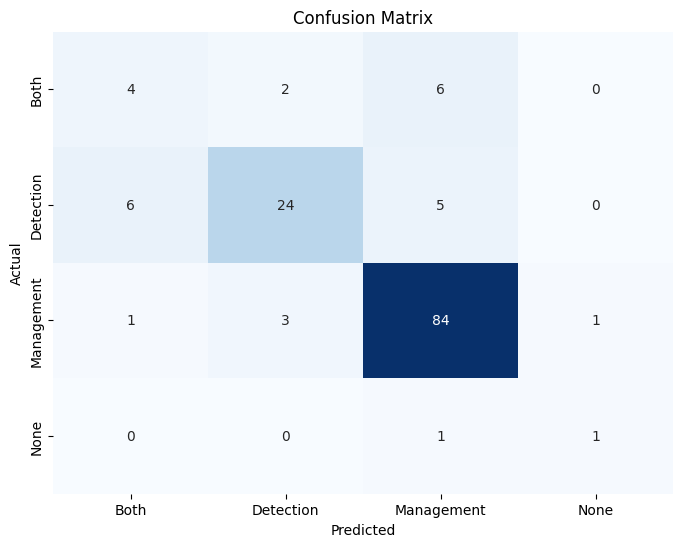

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues", cbar=False, xticklabels=classifier.classes_, yticklabels=classifier.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [ ]:


for model in ["log_regression", "log_regression_balanced", "knn", "random_forest", "sgd", "svm"]:
    # Initialise wandb run
    
    # Creating the classifier
    if model == "log_regression":
        classifier = LogisticRegression(penalty="l2", random_state=SEED, multi_class='multinomial')        
    if model == "log_regression_balanced":
        classifier = LogisticRegression(penalty="l2", random_state=SEED, multi_class='multinomial', class_weight='balanced')
    elif model == "knn":
        classifier = KNeighborsClassifier()
    elif model == "random_forest":
        classifier = RandomForestClassifier(random_state=SEED)
    elif model == "sgd":
        classifier = SGDClassifier(random_state=SEED)
    elif model == "svm":
        classifier = LinearSVC(random_state=SEED)

    # Fitting the model
    classifier.fit(X_train, Y_train)
    # Predicting on the validation set
    predictions = classifier.predict(X_val)

    # Creating metrics
    metrics = classification_utils.create_average_metrics(
        Y_val, predictions, average="micro"
    )
    logging.info(metrics)

    # # Creating confusion matrix
    # confusion_matrix = classification_utils.plot_confusion_matrix(
    #     Y_val, predictions, None, "Relevant works"
    # )

    # Save model to S3
    S3.upload_obj(
        obj=classifier,
        bucket=S3_BUCKET,
        path_to=f"{S3_PATH}gpt_labelled_detection_management_classifier_{model}.pkl",
    )

    if args.wandb:
        # Log metrics
        wandb.run.summary["f1"] = metrics["f1"]
        wandb.run.summary["accuracy"] = metrics["accuracy"]
        wandb.run.summary["precision"] = metrics["precision"]
        wandb.run.summary["recall"] = metrics["recall"]

        # Adding reference to this model in wandb
        wb.add_ref_to_data(
            run=run,
            name=f"detection_management_classifier_{model}",
            description=f"{model} model for classifying detection-management",
            bucket=S3_BUCKET,
            filepath=f"{S3_PATH}gpt_labelled_detection_management_classifier_{model}.pkl",
        )

        # # Log confusion matrix
        # wb_confusion_matrix = wandb.Table(
        #     data=confusion_matrix, columns=confusion_matrix.columns
        # )
        # run.log({"confusion_matrix": wb_confusion_matrix})

        # End the weights and biases run
        wandb.finish()


[(0, 4674), (1, 4674), (2, 4674)]


In [22]:
print(sorted(Counter(y).items()))

[(0, 64), (1, 262), (2, 4674)]
